In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from pathlib import Path


output_dir = Path('../tables_and_figures/')
##https://apps.bea.gov/national/Release/XLS/Survey/Section1All_xls.xlsx

df=pd.read_excel('https://apps.bea.gov/national/Release/XLS/Survey/Section1All_xls.xlsx','T11500-Q',skiprows=7).query('Line in ["1","2","3","7","8","9"]').iloc[:,-26:]
df.index=['Prices','Labor','Other Inputs','Profits','Taxes','AfterTax']
df2=df.transpose()
df2.index=pd.to_datetime(list(df2.index))
df2 = df2.apply(pd.to_numeric, errors='coerce').dropna()  # drop unreleased quarters (BEA marks them ".....")

df_raw = df2.copy()

raw_labels = ['{} Q{}'.format(y,q) for y,q in zip(df_raw.index.year, df_raw.index.quarter)]
df3 = df2.copy()
df3.index = raw_labels
df3.to_latex(output_dir / 'nipa_table_115.tex',header=['Prices','Labor','Nonlabor','Profits','Taxes','After Tax Profits'],float_format="%.3f")

/var/folders/3c/6cgp3y4n5svbnrtm237wj5680000gn/T/ipykernel_32685/1202387522.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2.index=pd.to_datetime(list(df2.index))


In [2]:
# Compute delta relative to the last row
df_delta = df2.rsub(df2.iloc[-1]).iloc[:-1]

# Normalize by Prices and select relevant columns
cols = ['Labor', 'Other Inputs', 'Profits', 'Taxes', 'AfterTax']
df_out = df_delta[cols].div(df_delta['Prices'], axis=0)

# Round for presentation
df_out.round(3)

,Labor,Other Inputs,Profits,Taxes,AfterTax
2019-04-01,0.459,0.165,0.384,0.103,0.281
2019-07-01,0.479,0.160,0.366,0.105,0.256
2019-10-01,0.466,0.175,0.359,0.103,0.256
2020-01-01,0.409,0.165,0.426,0.117,0.309
2020-04-01,0.294,0.328,0.382,0.101,0.282
2020-07-01,0.396,0.431,0.178,0.084,0.093
2020-10-01,0.403,0.287,0.315,0.097,0.218
2021-01-01,0.464,0.319,0.222,0.087,0.135
2021-04-01,0.484,0.398,0.124,0.070,0.059
2021-07-01,0.464,0.369,0.173,0.071,0.101


In [3]:
def make_pretty(styler):
    styler.set_caption("Share of Price Changes (Value Added) Through Q3 2025")\
    .set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: top; font-size:1.25em;'
    }], overwrite=False)
    #styler.background_gradient()
    styler.format(precision=1)
    return styler


df_out2=df_out[(df_out.index.month==7)].copy()
df_out2.index = df_out2.index.year

df_table=100*df_out2.transpose().copy()
df_table.index = ['Labor','Nonlabor','Profits','Taxes','Profits After Tax']

df_table.iloc[0:5,:].to_latex(output_dir /'nipa_factor_shares.tex',float_format="%.1f")
df_table.round(2)

#dfi.export(df_table.style.pipe(make_pretty), 'df_q3_on_q3.png',dpi=200)
#dfi.export(df_table3.style.pipe(make_pretty), 'df_annual.png',dpi=200)


,2019,2020,2021,2022,2023,2024
Labor,47.90,39.56,46.43,57.83,51.02,40.0
Nonlabor,15.97,43.11,36.90,25.30,48.98,64.0
Profits,36.55,17.78,17.26,18.07,2.04,-4.0
Taxes,10.50,8.44,7.14,3.61,4.08,-4.0
Profits After Tax,25.63,9.33,10.12,14.46,-2.04,4.0


In [4]:
def compute_change_weights(
    df,
    value_col,
    annual_month=None,
    normalize=True,
    dropna=True
):
    """
    Compute contribution weights based on period-to-period changes
    of a given column.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a DatetimeIndex.
    value_col : str
        Column to compute weights from (e.g. 'Prices', 'ValueAdded').
    annual_month : int or None
        If provided (1–12), compute year-over-year weights using that
        month as the anchor (e.g. 7 for July-to-July).
        If None, return per-period weights.
    normalize : bool
        If True, divide by total change so weights sum to 1.
    dropna : bool
        If True, drop missing values after differencing.

    Returns
    -------
    pd.Series
        Weight series indexed by date or year.
    """
    # Period-to-period change
    diff = df[value_col].diff()

    if dropna:
        diff = diff.fillna(0)

    if normalize:
        total = diff.sum()
        if total == 0:
            raise ValueError(f"Total change in {value_col} is zero.")
        diff = diff / total

    # Annual (e.g. July-to-July) aggregation
    if annual_month is not None:
        anchored = diff.cumsum()
        annual = anchored[anchored.index.month == annual_month].diff()
        annual = annual.dropna()
        annual.index = annual.index.year
        annual.name = 'weight'
        return annual

    diff.name = 'weight'
    return diff

a=compute_change_weights(df2, value_col='Prices', annual_month=7)
b=compute_change_weights(df2, value_col='AfterTax', annual_month=7)

# Share of Price/Profit changes by year
pd.concat([a,b],axis=1,keys=['Prices','AfterTax']).round(3)


,Prices,AfterTax
2020,0.054,0.588
2021,0.236,0.059
2022,0.351,0.074
2023,0.140,0.191
2024,0.099,-0.029
2025,0.103,0.015


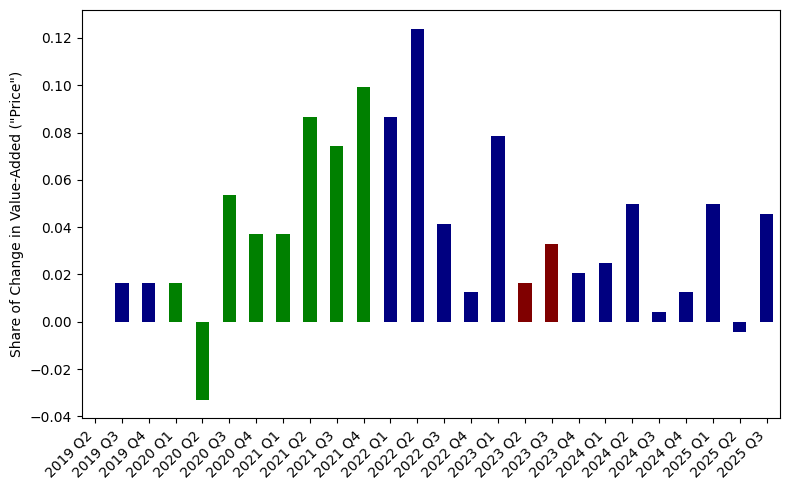

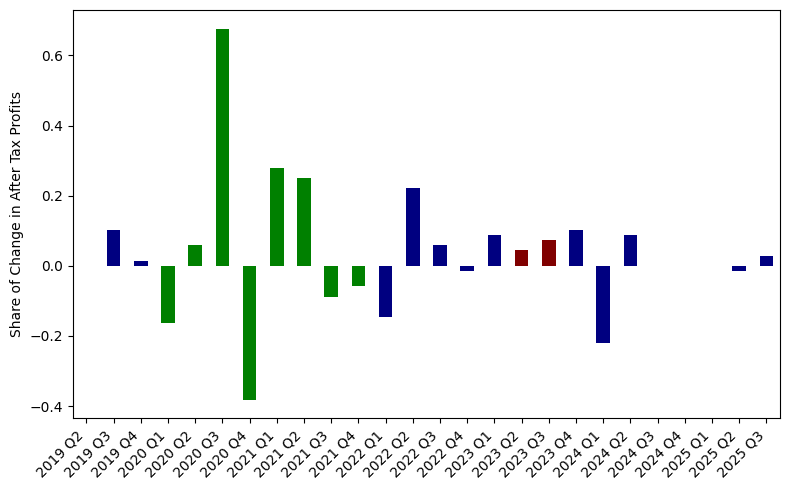

<Axes: ylabel='Share of Change in After Tax Profits'>

In [5]:
# Period-to-period price changes
def plot_weights(weights, y_label='Share of Change in Value-Added ("Price")', output_file='price_weights.pdf'):
    labels = ['{} Q{}'.format(y,q) for y,q in zip(weights.index.year, weights.index.quarter)]

    def get_color(label):
        if label in {'2023 Q2', '2023 Q3'}:
            return 'maroon'
        elif label.startswith(('2020', '2021')):
            return 'green'
        else:
            return 'navy'

    colors = [get_color(l) for l in labels]

    ax = weights.reset_index(drop=True).plot(kind='bar', color=colors, figsize=(8, 5))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(y_label)
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

    return ax

plot_weights(compute_change_weights(df2, value_col='Prices'), y_label='Share of Change in Value-Added ("Price")', output_file=output_dir/'price_weights.pdf')
plot_weights(compute_change_weights(df2, value_col='AfterTax'), y_label='Share of Change in After Tax Profits', output_file=output_dir/'profit_weights.pdf')

<function matplotlib.pyplot.show(close=None, block=None)>

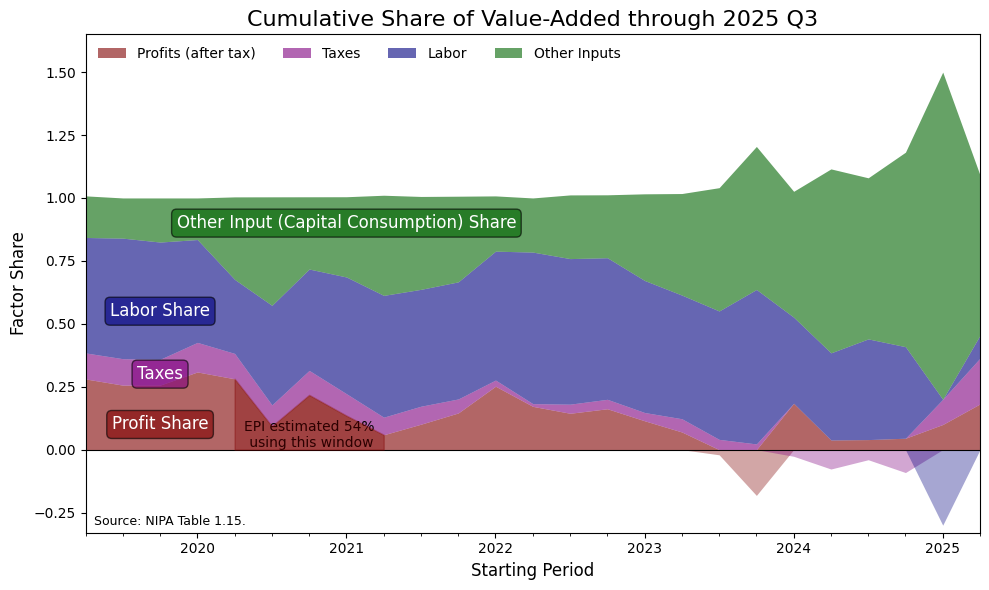

In [6]:
# ---- Prepare data ----
cols = ['AfterTax','Taxes','Labor', 'Other Inputs']
df_plot = df_out[cols].copy()

# Positive and negative parts
df_pos = df_plot.clip(lower=0)   # keep only positive values
df_neg = df_plot.clip(upper=0)   # keep only negative values (<=0)

# Color map for consistency
colors = {'Labor': 'navy', 'Other Inputs': 'darkgreen', 'AfterTax': 'maroon','Taxes':'purple'}

# ---- Plot positives: stacked area ----
fig, ax = plt.subplots(figsize=(10, 6))
df_pos.plot.area(ax=ax, color=[colors[c] for c in cols], alpha=0.6, linewidth=0)

# ---- Plot negatives: fill below zero for each column ----
# We plot each negative series with the same color but a different alpha so it's distinguishable.
for c in cols:
    neg = df_neg[c]
    if (neg != 0).any():
        ax.fill_between(
            neg.index,
            0,
            neg,                       # neg is <=0 so this fills downward
            where=neg < 0,
            interpolate=True,
            color=colors[c],
            alpha=0.35,
            linewidth=0,
            label=f'{c} (negative)'
        )

# ---- Styling ----
# Create a clean legend (combine positive and negative labels; remove duplicate labels)
handles, labels = ax.get_legend_handles_labels()
# keep unique labels in order
seen = set()
unique = []
unique_labels = []
for h, lab in zip(handles, labels):
    if lab not in seen:
        seen.add(lab)
        unique.append(h)
        unique_labels.append(lab)
        unique_labels = [lab.replace('AfterTax', 'Profits (after tax)') for lab in unique_labels]
ax.legend(unique[0:4], unique_labels[0:4], loc='upper left', ncol=4,frameon=False)

ax.axhline(0, color='k', linewidth=0.8)          # zero baseline
ax.set_ylabel('Factor Share', fontsize=12)
ax.set_xlabel('Starting Period', fontsize=12)
ax.set_title('Cumulative Share of Value-Added through 2025 Q3', fontsize=16)

# Automatic y-limits that include both positive stack and negative trough
ymin = min(df_neg.min().min() * 1.1, -0.2)
ymax = max(df_pos.sum(axis=1).max() * 1.1, 1.0)
ax.set_ylim(ymin, ymax)

# ---- Annotations: use pd.Timestamp so positions align with index type ----
ax.annotate('Profit Share', xy=(pd.Timestamp('2019-10-01'), 0.1),
            color='white', fontsize=12, ha='center', va='center',
            bbox=dict(facecolor=colors['AfterTax'], alpha=0.6, boxstyle='round,pad=0.3'))

ax.annotate('Labor Share', xy=(pd.Timestamp('2019-10-01'), 0.55),
            color='white', fontsize=12, ha='center', va='center',
            bbox=dict(facecolor=colors['Labor'], alpha=0.6, boxstyle='round,pad=0.3'))

ax.annotate('Taxes', xy=(pd.Timestamp('2019-10-01'), 0.30),
            color='white', fontsize=12, ha='center', va='center',
            bbox=dict(facecolor=colors['Taxes'], alpha=0.6, boxstyle='round,pad=0.3'))


ax.annotate('Other Input (Capital Consumption) Share', xy=(pd.Timestamp('2021-01-01'), 0.9),
            color='white', fontsize=12, ha='center', va='center',
            bbox=dict(facecolor=colors['Other Inputs'], alpha=0.6, boxstyle='round,pad=0.3'))

# small source note in lower-left inside axes #Figure by cconlon@stern
ax.annotate('Source: NIPA Table 1.15.' ,
            xy=(0.01, 0.01), xycoords='axes fraction', fontsize=9, va='bottom')

# example explanatory annotation and horizontal reference line
ax.annotate("EPI estimated 54%\n using this window",
            xy=(pd.Timestamp('2020-10-01'), 0.01), xycoords='data',
            xytext=(pd.Timestamp('2020-10-01'), 0.01),
            fontsize=10, ha='center')

# ---- Define EPI window ----
start = pd.Timestamp('2020-04-01')   # 2020Q2
end   = pd.Timestamp('2021-06-30')   # 2021Q2

# Profit layer bounds in the stacked area
bottom = 0
top    = df_pos['AfterTax']

# Restrict to EPI period
mask = (df_out.index >= start) & (df_out.index <= end)

# Shade only the profit layer
ax.fill_between(
    df_out.index,
    bottom,
    top,
    where=mask & (df_pos['AfterTax'] > 0),
    interpolate=True,
    color='maroon',
    alpha=0.35,
    zorder=4,
    label='Profits (EPI period)'
)

# Tight layout and save
plt.tight_layout()

plt.savefig(output_dir / 'greedflation_bars.pdf', bbox_inches='tight')
plt.savefig(output_dir / 'greedflation_bars.png', bbox_inches='tight')
plt.show

In [7]:
def compare_fixed_interval(df_raw, start_date, end_date):
    diff = df_raw.loc[end_date] - df_raw.loc[start_date]
    if diff['Prices'] == 0:
        return diff * np.nan
    return diff.div(diff['Prices']) * 100

def compare_k_quarter_windows(df_raw, k=1, agg_method='last'):
    """
    Compute (X_{t+k} - X_t) / (Prices_{t+k} - Prices_t) * 100 for all possible
    windows spanning k quarters.

    Parameters
    ----------
    df_raw : pd.DataFrame
        Time-indexed dataframe (DateTimeIndex or convertible) containing at least 'Prices'
    k : int
        Number of quarters between start and end. k=1 -> consecutive quarters.
    agg_method : {'last','first','mean'}
        How to reduce multiple timestamps inside a quarter to a single quarterly observation.

    Returns
    -------
    pd.DataFrame
        Each row corresponds to a start->end window. Columns are the result of the percentage
        calculation for every column in df_raw, plus metadata columns:
        - start (Timestamp), end (Timestamp), start_q (Period), end_q (Period)
    """
    if k < 1:
        raise ValueError("k must be >= 1")

    # --- Normalize to one row per quarter ---
    # Convert index to quarterly timestamp (period start)
    df_q = df_raw.copy()
    df_q.index = pd.to_datetime(df_q.index)  # ensure datetime-like
    q_idx = df_q.index.to_period('Q')

    df_q = df_q.assign(_q=q_idx)

    if agg_method == 'last':
        df_q = df_q.groupby('_q').last()
    elif agg_method == 'first':
        df_q = df_q.groupby('_q').first()
    elif agg_method == 'mean':
        df_q = df_q.groupby('_q').mean()
    else:
        raise ValueError("agg_method must be one of 'last','first','mean'")

    # After grouping, the index is PeriodIndex; convert to a Timestamp at quarter start
    df_q.index = df_q.index.to_timestamp()  # timestamps at quarter start
    df_q = df_q.sort_index()

    periods = df_q.index.to_period('Q')  # PeriodIndex for nice labels
    n = len(df_q)
    if n <= k:
        raise ValueError(f"Not enough quarterly observations ({n}) for k={k} windows")

    rows = []
    for i in range(n - k):
        start_ts = df_q.index[i]
        end_ts   = df_q.index[i + k]

        start_p = start_ts.to_period('Q')
        end_p   = end_ts.to_period('Q')

        diff = df_q.loc[end_ts] - df_q.loc[start_ts]

        # Guard: if price diff is zero -> results undefined, produce NaNs
        price_diff = diff.get('Prices', np.nan)
        if pd.isna(price_diff) or price_diff == 0:
            pct = (diff * np.nan)  # preserve columns but all NaN
        else:
            pct = diff.div(price_diff) * 100

        # Build row (keep pct values + metadata)
        row = pct.to_dict()
        row.update({
            'start': start_ts,
            'end': end_ts,
            'start_q': str(start_p),
            'end_q': str(end_p),
            'k_quarters': k
        })
        rows.append(row)

    result = pd.DataFrame(rows)

    # Make a readable index label like "2020Q2–2021Q1"
    result_index = [f"{r['start_q']}–{r['end_q']}" for _, r in result.iterrows()]
    result.index = pd.Index(result_index, name='window')

    # Reorder meta columns to the end (so component columns appear first)
    meta_cols = ['start', 'end', 'start_q', 'end_q', 'k_quarters']
    # ensure meta_cols exist (they should)
    cols = [c for c in result.columns if c not in meta_cols] + meta_cols
    result = result[cols]

    return result

# reverse engineer Groundwork's analysis by printing all (1,2,3) quarter windows
df_out_1 = compare_k_quarter_windows(df_raw, k=1, agg_method='last').round(1)
df_out_2 = compare_k_quarter_windows(df_raw, k=2, agg_method='last').round(1)
df_out_3 = compare_k_quarter_windows(df_raw, k=3, agg_method='last').round(1)

print(df_out_1.iloc[12:20,1:6])
print(df_out_2.iloc[12:20,1:6])
print(df_out_3.iloc[12:20,1:6])

               Labor  Other Inputs  Profits  Taxes  AfterTax
window                                                      
2022Q2–2022Q3   80.0         -10.0     30.0  -20.0      40.0
2022Q3–2022Q4  100.0          33.3    -33.3    0.0     -33.3
2022Q4–2023Q1   68.4          -5.3     36.8    5.3      31.6
2023Q1–2023Q2  100.0         -50.0     50.0  -25.0      75.0
2023Q2–2023Q3   37.5         -12.5     75.0   12.5      62.5
2023Q3–2023Q4  -40.0         -20.0    160.0   20.0     140.0
2023Q4–2024Q1  233.3         100.0   -233.3   33.3    -250.0
2024Q1–2024Q2   33.3           0.0     66.7    8.3      50.0
               Labor  Other Inputs  Profits  Taxes  AfterTax
window                                                      
2022Q2–2022Q4   84.6           0.0     15.4  -15.4      23.1
2022Q3–2023Q1   72.7           0.0     27.3    4.5      22.7
2022Q4–2023Q2   73.9         -13.0     39.1    0.0      39.1
2023Q1–2023Q3   58.3         -25.0     66.7    0.0      66.7
2023Q2–2023Q4    7.7    

In [8]:
# EPI study
print(compare_fixed_interval(df_raw, '2020-04-01', '2021-10-01'))
print(df_raw.loc['2021-10-01'])
print(df_raw.loc['2020-04-01'])


Prices          100.000000
Labor             3.191489
Other Inputs     30.851064
Profits          65.957447
Taxes            17.021277
AfterTax         48.936170
dtype: float64
Prices          1.135
Labor           0.655
Other Inputs    0.285
Profits         0.195
Taxes           0.036
AfterTax        0.159
Name: 2021-10-01 00:00:00, dtype: float64
Prices          1.041
Labor           0.652
Other Inputs    0.256
Profits         0.133
Taxes           0.020
AfterTax        0.113
Name: 2020-04-01 00:00:00, dtype: float64


In [9]:
# Groundwork (best guess) study
print(compare_fixed_interval(df_raw, '2023-01-01', '2023-07-01'))
print(df_raw.loc['2023-01-01'])
print(df_raw.loc['2023-07-01'])


Prices          100.000000
Labor            58.333333
Other Inputs    -25.000000
Profits          66.666667
Taxes             0.000000
AfterTax         66.666667
dtype: float64
Prices          1.218
Labor           0.690
Other Inputs    0.313
Profits         0.215
Taxes           0.042
AfterTax        0.173
Name: 2023-01-01 00:00:00, dtype: float64
Prices          1.230
Labor           0.697
Other Inputs    0.310
Profits         0.223
Taxes           0.042
AfterTax        0.181
Name: 2023-07-01 00:00:00, dtype: float64


In [10]:
# Groundwork (best guess) study
print(compare_fixed_interval(df_raw, '2022-01-01', '2023-01-01'))
print(df_raw.loc['2022-01-01'])
print(df_raw.loc['2023-01-01'])

Prices          100.000000
Labor            50.000000
Other Inputs      9.677419
Profits          40.322581
Taxes             1.612903
AfterTax         38.709677
dtype: float64
Prices          1.156
Labor           0.659
Other Inputs    0.307
Profits         0.190
Taxes           0.041
AfterTax        0.149
Name: 2022-01-01 00:00:00, dtype: float64
Prices          1.218
Labor           0.690
Other Inputs    0.313
Profits         0.215
Taxes           0.042
AfterTax        0.173
Name: 2023-01-01 00:00:00, dtype: float64


In [11]:
# How low were profits in Q1 2020?
df=pd.read_excel('https://apps.bea.gov/national/Release/XLS/Survey/Section1All_xls.xlsx','T11500-Q',skiprows=7).query('Line in ["1","2","3","7","8","9"]').iloc[:,-75:]
df.index=['Prices','Labor','Other Inputs','Profits','Taxes','AfterTax']
df2=df.transpose()
df2.index=pd.to_datetime(list(df2.index))
df2 = df2.apply(pd.to_numeric, errors='coerce').dropna()  # drop unreleased quarters

df2.query('Profits <= .126')

/var/folders/3c/6cgp3y4n5svbnrtm237wj5680000gn/T/ipykernel_32685/583848419.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2.index=pd.to_datetime(list(df2.index))


,Prices,Labor,Other Inputs,Profits,Taxes,AfterTax
2007-01-01,0.850,0.504,0.229,0.117,0.035,0.082
2007-04-01,0.856,0.505,0.233,0.119,0.034,0.084
2007-07-01,0.862,0.514,0.241,0.108,0.032,0.076
2007-10-01,0.863,0.513,0.243,0.106,0.030,0.076
2008-01-01,0.866,0.520,0.248,0.098,0.029,0.070
2008-04-01,0.869,0.520,0.252,0.098,0.027,0.070
2008-07-01,0.876,0.514,0.251,0.111,0.026,0.085
2008-10-01,0.890,0.531,0.261,0.097,0.017,0.080
2009-01-01,0.893,0.530,0.271,0.092,0.018,0.074
2009-04-01,0.888,0.532,0.271,0.085,0.020,0.065
